In [1]:
from ase.io import read, write 
from ase import atoms 
from ase.io.vasp import read_vasp
from ase.visualize import view
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
import random
import numpy as np
from ase.md import MDLogger
from ase.md.npt import NPT
from ase import units
from mace.calculators import mace_mp
from tqdm import tqdm
from ase.md.analysis import DiffusionCoefficient
import os
import matplotlib.pyplot as plt

In [8]:
import utils.diff_coeff as diff

In this notebook

lets first begin by visualising the g-Li3PS4 structure

next we will initialise the MACE-MP0-0 calculator that is available within ASE

We can then attach this to our structure and run some NVT MD

from this MD we can then extract a diffusion constant 

In this next section, you will use the diff_coeff file that is found in utils to run MD using MACE-MP-0. The aim is to run it for multiple temperatures with multiple repeats at each temperature. This will allow us to calculate an average temperature, with errors, and extrapolate to a room temperature diffusion constant, while proppogating the errors.

the first place to start is the diff.diffusion_plot function
This function automates the running, caclculation and extrapolation of dissplacement constants and serves as an example of how to set up the system.

In [ ]:
def diffusion_plot(structure_file,temp_arr=[525], repeats=5, ts=2*units.fs, tts=80*units.fs, step=100, atom='Li', start=0, model='medium', floats='float32'):
    #set up and run the md, in this case the paralel cpu implementation
    diff.run_md_bash(structure, temp_arr, repeats, ts, tts, step, model, floats)
    
    #read in the diffusion coefficients from the generated files
    dict_diff_coeff = diff.extract_diff_coeff(temp_arr, repeats, atom, start, ts)
    
    #plot the diffusion constants and extract the coefficients, covarience 
    coefficients,cov = diff.plot_average_diff_coeff(dict_diff_coeff)
    return coefficients, dict_diff_coeff,cov


In [ ]:
coefficients,dict_diff_coeff,cov = diff.diffusion_plot(
    structure_file='g_li3ps4.xyz',
    temp_arr=[800,1000,1200], 
    repeats=5, 
    ts=2*units.fs, 
    tts=80*units.fs, 
    step=10, 
    atom='Li', 
    start=0, 
    model='small', 
    floats='float32',
    device='cpu'
    )

room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

when defining your diffusion plot function there are some options.
the first of this is how you run the MD
you have an option of run_md_bash or run_md. the run md option will simply run the vairous temperatures and repeats sequentially, this is good for GPUs where the calculations will use the whole GPU and will run faster. run_md_bash works by first making a bash script that attempts to launch all temperature and repeats at the same time. This is well suited to cpu where MACE can only use one core, this in effect allows us to parallelise calculations


following this, we also have a choice in what you wish to plot, the choice here is between plot_average_diff_coeff and plot_diff_coeff. plot_diff_coeff will plot all calculated diffusion constants, and plot_average_diff_coeff will plot the average diffusion constant at a given temperature. Both will calculate a line of best fit and output the coefficients and the covariance matrix.

feel free to play around with some of the parameters but keep in mind that making the models larger will make them more expensive. another consideration for evaluation for evaluation on hetmathsys is that there are only 40 cores available, as such the length of your temperature array * the number of repitions should ideally be below 40 as the runs will be launched at the same time and will each require 1 cpu. In the case that you want to do more than 40 total calculations this is possible by splitting up the calculations like shown below

In [ ]:
structure_file='g_li3ps4.xyz'
repeats=10
ts=2*units.fs
tts=80*units.fs 
step=10
atom='Li'
start=0
model='small'
floats='float32'
device='cpu'



#set up and run the md, in this case the paralel cpu implementation

temp_arr=[100,200,300,400]
diff.run_md_bash(structure_file, temp_arr, repeats, ts, tts, step, model, floats, device)

temp_arr=[500,600,700,800]
diff.run_md_bash(structure_file, temp_arr, repeats, ts, tts, step, model, floats, device)



#read in the diffusion coefficients from the generated files
temp_arr=[100,200,300,400,500,600,700,800]
dict_diff_coeff = diff.extract_diff_coeff(temp_arr, repeats, atom, start, ts)

#plot the diffusion constants and extract the coefficients, covarience 
coefficients,cov = diff.plot_average_diff_coeff(dict_diff_coeff)

room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

you can see above that for the calculations we can give multiple sets of arrays to each run, and combine the temperature arrays when we come to extracting the coefficients. this is because when the MD is run, it is saved to a file name including the temperature and repetition. For this to work you need to ensure number of repitions is consistent in each run. note that running the simulation again will overwrite the saved files.

Finally for the reproducible result, you are welcome to experiment with some parameters, you should do 1 production run at 800K,1000K,1200K and 1400K. using 5 repitions. from this you should plot the graph of the diffusion constants and extract the diffusion constant at 300K compare this to a precalculated value of ----

In [ ]:
coefficients,dict_diff_coeff,cov = diff.diffusion_plot(
    structure_file='g_li3ps4.xyz',
    temp_arr=[800,1000,1200,1400], 
    repeats=5, 
    ts=2*units.fs, 
    tts=80*units.fs, 
    step=10000, 
    atom='Li', 
    start=0, 
    model='medium', 
    floats='float32',
    device='cpu'
    )

room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

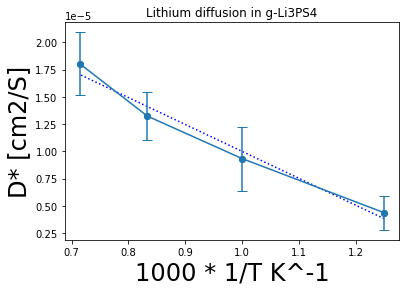

The estimated room temperature difussion coefficient  -4.759654722236029e-05  +-  1.0264287751301762e-05  cm2/s


In [3]:
structure_file='g_li3ps4.xyz'
temp_arr=[800,1000,1200,1400]
repeats=5
ts=2*units.fs 
tts=80*units.fs 
step=10000
atom='Li' 
start=0
model='medium' 
floats='float32'
device='cpu'

#read in the diffusion coefficients from the generated files
dict_diff_coeff = diff.extract_diff_coeff(temp_arr, repeats, atom, start, ts)

#plot the diffusion constants and extract the coefficients, covarience 
coefficients,cov = diff.plot_average_diff_coeff(dict_diff_coeff)


room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

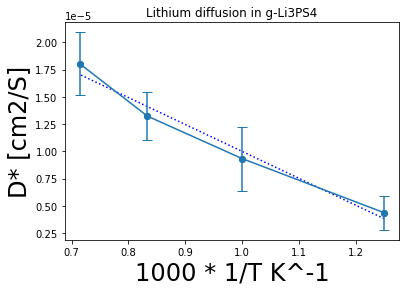

[-2.46800527e-05  3.46702951e-05] [[ 9.18988422e-12 -8.72491984e-12]
 [-8.72491984e-12  8.65491469e-12]]
The estimated room temperature difussion coefficient  -4.759654722236029e-05  +-  1.0264287751301762e-05  cm2/s


In [7]:
coefficients,cov = diff.plot_average_diff_coeff(dict_diff_coeff)
print(coefficients,cov)

room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

The estimated room temperature difussion coefficient  -4.7596547222360344e-05  +-  9.378795746619728e-06  cm2/s

[-2.46800527e-05  3.46702951e-05] [[ 9.18988422e-12 -8.72491984e-12]
 [-8.72491984e-12  8.65491469e-12]]


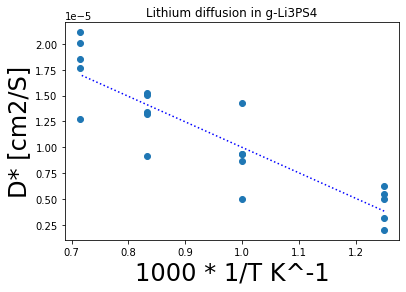

The estimated room temperature difussion coefficient  -4.759654722236029e-05  +-  1.0264287751301762e-05  cm2/s


In [5]:
#plot the diffusion constants and extract the coefficients, covarience 
coefficients,cov = diff.plot_diff_coeff(dict_diff_coeff)


room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')